In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.0 MB/s eta 0:00:00


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: Tesla T4
Dataset Configured. Classes detected: {0: 'mouse_bite', 1: 'spur', 2: 'missing_hole', 3: 'short', 4: 'open_circuit', 5: 'spurious_copper'}

Starting YOLOv8 Training on PCB Dataset...
Ultralytics 8.3.250 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=pcb_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, e

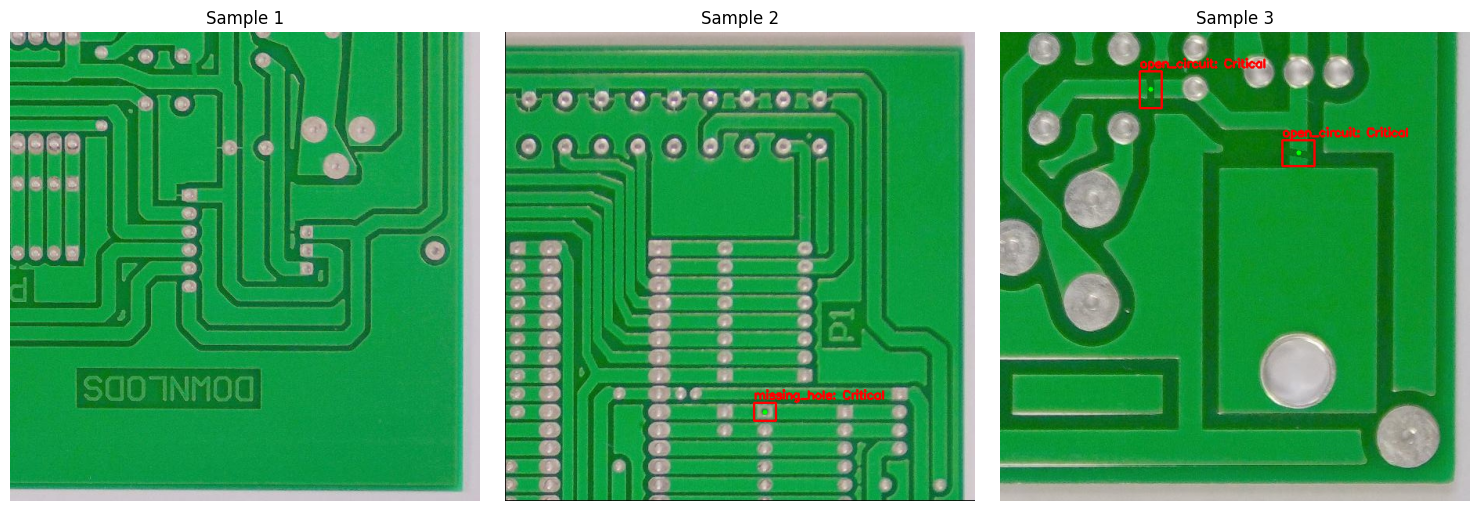


PCB Inspection Complete.


In [3]:
import os
import cv2
import numpy as np
import shutil
import yaml
import matplotlib.pyplot as plt
from glob import glob
from ultralytics import YOLO
import torch

# ==========================================
# 0. SETUP & DATASET CONFIGURATION
# ==========================================
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# 1. Define Dataset Path (Matches the structure in your image)
# Assuming the folder 'pcb-defect-dataset' is in the current directory
dataset_root = os.path.abspath("/kaggle/input/pcb-defect-dataset/pcb-defect-dataset")

# 2. Check if dataset exists
if not os.path.exists(dataset_root):
    raise FileNotFoundError(f"Dataset not found at {dataset_root}. Please check the path.")

# 3. Fix/Create data.yaml for YOLO
# We need to ensure the yaml points to absolute paths to avoid errors
yaml_path = os.path.join(dataset_root, "data.yaml")

# Read existing names from the yaml if possible, or define standard PCB classes
# (This step ensures we know what classes we are dealing with)
with open(yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

# Update paths in yaml to be absolute
data_config['path'] = dataset_root
data_config['train'] = "train/images"
data_config['val'] = "val/images"
data_config['test'] = "test/images"

# Save the corrected yaml
with open("pcb_data.yaml", "w") as f:
    yaml.dump(data_config, f)

print(f"Dataset Configured. Classes detected: {data_config['names']}")

# ==========================================
# 1. TRAIN YOLOv8 (On PCB Data)
# ==========================================
print("\nStarting YOLOv8 Training on PCB Dataset...")
model = YOLO("yolov8m.pt") 

# Train
results = model.train(
    data="pcb_data.yaml",
    epochs=30, 
    imgsz=640, 
    batch=16, 
    plots=True,
    verbose=False
)

print(f"\nTraining Complete. Best Model saved at: {results.save_dir}/weights/best.pt")

# ==========================================
# 2. DEFECT ANALYSIS SCRIPT (PCB Specific)
# ==========================================
# Requirements: Output (x, y), Severity, Class

def analyze_defects(image_path, model):
    img = cv2.imread(image_path)
    # Run inference
    results = model(image_path, verbose=False)[0]
    
    # Get class names from the model
    class_names = model.names
    
    print(f"\n--- Analysis Report for {os.path.basename(image_path)} ---")
    
    for box in results.boxes:
        # Extract Coordinates
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        conf = float(box.conf)
        cls_id = int(box.cls)
        label = class_names[cls_id]
        
        # Calculate Centers
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)
        width = x2 - x1
        height = y2 - y1
        
        # --- PCB SEVERITY LOGIC ---
        # Critical: Functional failures (Shorts, Opens, Missing parts)
        # Moderate: Reliability risks (Mouse bites, Spurs)
        # Low: Cosmetic (Spurious copper)
        
        label_lower = label.lower()
        if any(x in label_lower for x in ['open', 'short', 'missing', 'hole']):
            severity = "Critical"
        elif any(x in label_lower for x in ['bite', 'spur']):
            severity = "Moderate"
        else:
            severity = "Low" # Default for discoloration or spurious copper
            
        print(f"Defect: {label.upper()} | Loc: ({cx}, {cy}) | Severity: {severity} | Conf: {conf:.2f}")
        
        # Draw on Image
        # Red = Critical, Orange = Moderate, Yellow = Low
        if severity == "Critical":
            color = (0, 0, 255) 
        elif severity == "Moderate":
            color = (0, 165, 255)
        else:
            color = (0, 255, 255)

        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
        
        # Label Text
        text = f"{label}: {severity}"
        cv2.putText(img, text, (int(x1), int(y1)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        cv2.circle(img, (cx, cy), 3, (0, 255, 0), -1) # Mark center
        
    return img

# ==========================================
# 3. RUN INFERENCE ON SAMPLES
# ==========================================
# Pick 3 random test images from the PCB dataset
test_images = glob(f"{dataset_root}/test/images/*.jpg")[:3]

if not test_images:
    print("No test images found. Checking validation folder...")
    test_images = glob(f"{dataset_root}/val/images/*.jpg")[:3]

plt.figure(figsize=(15, 5))

for i, img_path in enumerate(test_images):
    analyzed_img = analyze_defects(img_path, model)
    
    # Convert BGR to RGB for Matplotlib
    analyzed_img_rgb = cv2.cvtColor(analyzed_img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, 3, i+1)
    plt.imshow(analyzed_img_rgb)
    plt.title(f"Sample {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

print("\nPCB Inspection Complete.")


image 1/1 /kaggle/input/pcb-defect-dataset/pcb-defect-dataset/test/images/light_04_short_05_2_600.jpg: 640x640 (no detections), 36.9ms
Speed: 2.4ms preprocess, 36.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


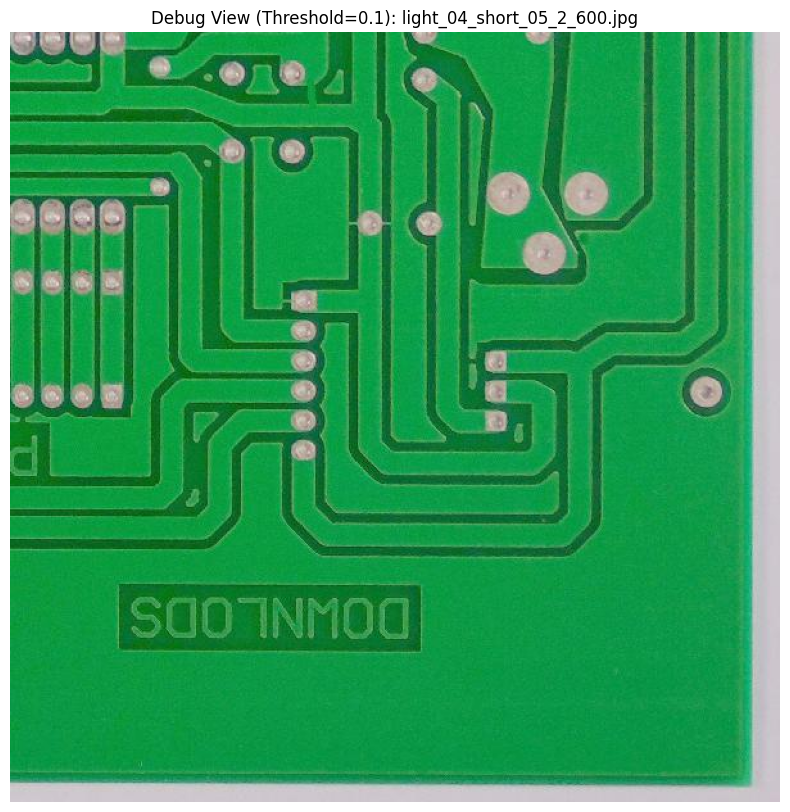

In [4]:
# Load your trained model
model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

# specific path to the failing image (update if needed)
target_img = "/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/test/images/light_04_short_05_2_600.jpg" 

# Run inference with a LOWER threshold (conf=0.1) to see faint detections
results = model(target_img, conf=0.1)

# Plot results
res_plotted = results[0].plot()
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.title(f"Debug View (Threshold=0.1): {os.path.basename(target_img)}")
plt.axis('off')
plt.show()